<a href="https://colab.research.google.com/github/jiiwon129/ESAA/blob/main/ESAA_YB_WEEK11_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **주택 가격 예측: Advanced**

### **[ 개념정리 ]**

1. 필요한 모듈 및 데이터 불러오기
  - 데이터 확인
2. Data Processing
  - 이상치(Outliers) 확인 후 제거
  - Target Variable
    - Q-Q Plot: 두 데이터 집단 간의 분포를 간단하게 체크
    - 분포가 비대칭적: 로그 변환(Log-Transformation) 진행
      - np.log1p()
3. Feature Engineering
  - 결측치(Missing value) 확인
    - 'None'으로 대체
    - 최빈값, 중앙값, 평균 등으로 대체
    - drop 함수 이용
  - Data correlation
  - Label Encoding & One-Hot Encoding
    - 범주형 데이터를 수치형 데이터로 변환
  - Skewed feature
    - Box-Cox Transformation: 정규 분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법 중 하나
4. Modeling
  - cross_val_score 함수 사용
    - cross_val_score 함수는 순서를 섞지 않음 -> 검증의 정확도를 높이기 위해 K-fold 사용
5. Base Models
  - LASSO Regression
    - 이상치에 매우 민감
    - pipeline의 RobustSclaer() 메서드 이용
  - Elastic Net Regression
    - 위와 동일
  - Kernel Ridge Regression
  - Gradient Boosting Regression
    - huber 손실함수(Loss Function)로 이상치 관리
    - huber 함수는 다른 손실함수에 비해 이상치에 대해 민감 x
  - XGBoost
  -LightGBM

### **[ 필사 ]**

#### 라이브러리, 데이터 확인

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm,skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# sns Theme
sns.set_style('darkgrid')

# 소수점 표현 제한
pd.set_option('display.float_format',lambda x : '{:.3f}'.format(x))

In [2]:
# 데이터 읽기
train_df=pd.read_csv('/content/drive/MyDrive/ESAA YB/dataset/House Prices - Advanced Regression Technique/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/ESAA YB/dataset/House Prices - Advanced Regression Technique/test.csv')

In [3]:
# 데이터 체크
print(train_df.shape,test_df.shape)
train_df.head()

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Id 칼럼은 데이터 분석과 상관 없는 특성
- drop 함수 이용

In [4]:
# Save the 'Id' column
train_ID=train_df['Id']
test_ID=test_df['Id']

# drop the 'Id' column since it's unnecessary for the prediction process
train_df.drop('Id',axis=1,inplace=True)
test_df.drop('Id',axis=1,inplace=True)

#### Data Processing

Outliers

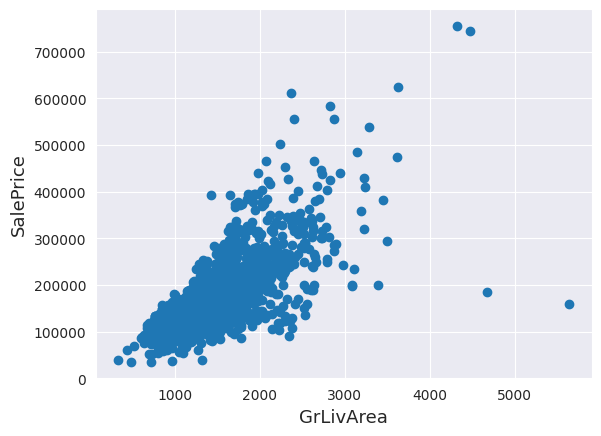

In [5]:
fig,ax=plt.subplots()

ax.scatter(x=train_df['GrLivArea'],y=train_df['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

2개의 이상치 발견

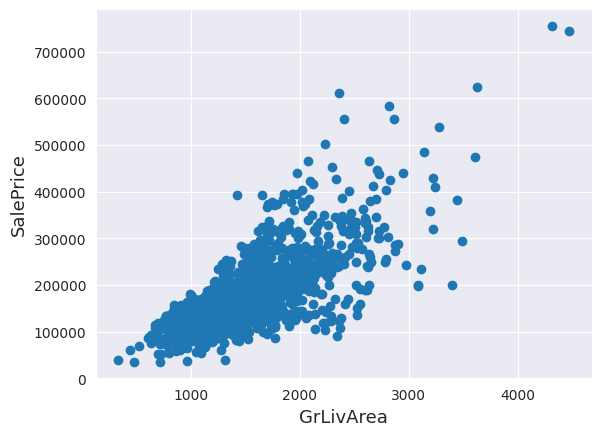

In [6]:
# Deleting outlier
train_df=train_df.drop(train_df[(train_df['GrLivArea']>4000)&(train_df['SalePrice']<300000)].index)

# Check the Graph again
fig,ax=plt.subplots()
ax.scatter(x=train_df['GrLivArea'],y=train_df['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea',fontsize=13)
plt.show()

#### Target Variable

Target 변수: 'SalePrice'

180932.91906721535 79467.78892987774


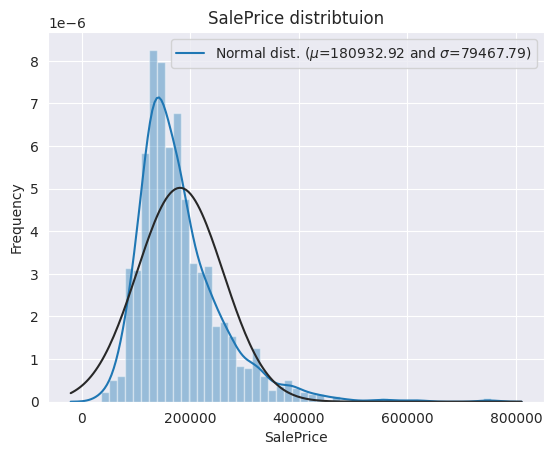

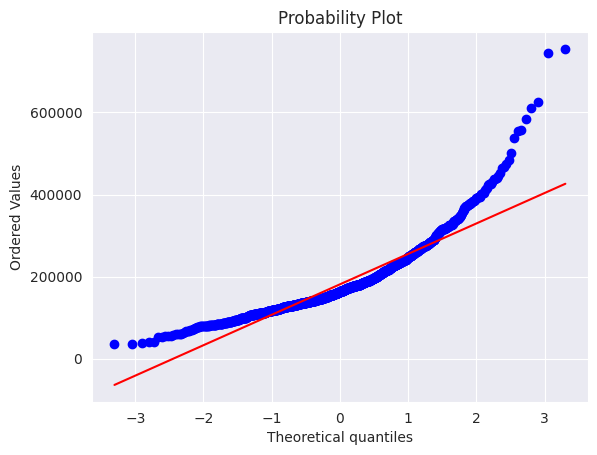

In [7]:
sns.distplot(train_df['SalePrice'],fit=norm)

# Get the fitted parameters used by the function
(mu, sigma)=norm.fit(train_df['SalePrice'])
print(mu,sigma)

# 분포를 그래프에 그려봅시다
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribtuion')

# QQ-Plot을 그려봅시다
fig=plt.figure()
res=stats.probplot(train_df['SalePrice'],plot=plt)
plt.show()

분포가 왼쪽으로 치우쳐져 있음
- 로그 변환(Log Transformation) 진행

Log-transformation of the target variable

numpy의 log1p() 이용

12.024015155682552 0.3995757283645756


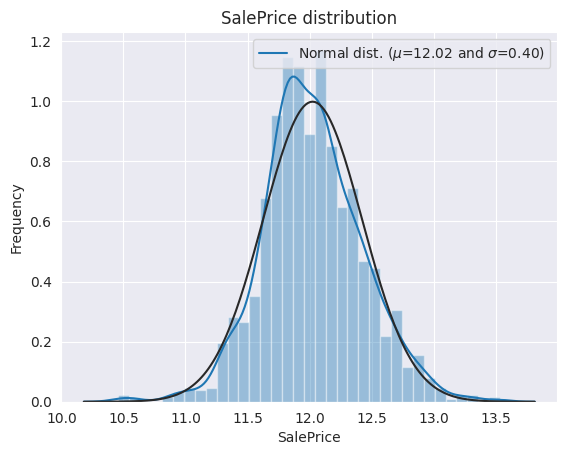

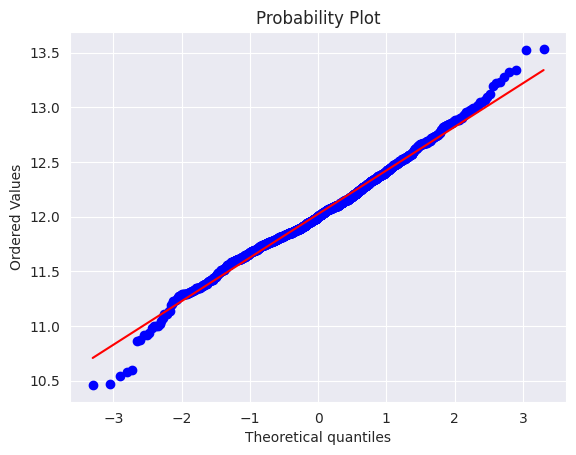

In [8]:
train_df['SalePrice']=np.log1p(train_df['SalePrice'])

sns.distplot(train_df['SalePrice'],fit=norm)
(mu,sigma)=norm.fit(train_df['SalePrice'])
print(mu,sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig=plt.figure()
res=stats.probplot(train_df['SalePrice'],plot=plt)
plt.show()

#### Feature Engineering

In [9]:
ntrain=train_df.shape[0]
ntest=test_df.shape[0]

y_train=train_df.SalePrice.values

all_data=pd.concat((train_df,test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'],axis=1,inplace=True)
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2917, 79)


Missing Data

In [10]:
all_data_na=(all_data.isnull().sum()/len(all_data))*100
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]

missing_data=pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageYrBlt,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

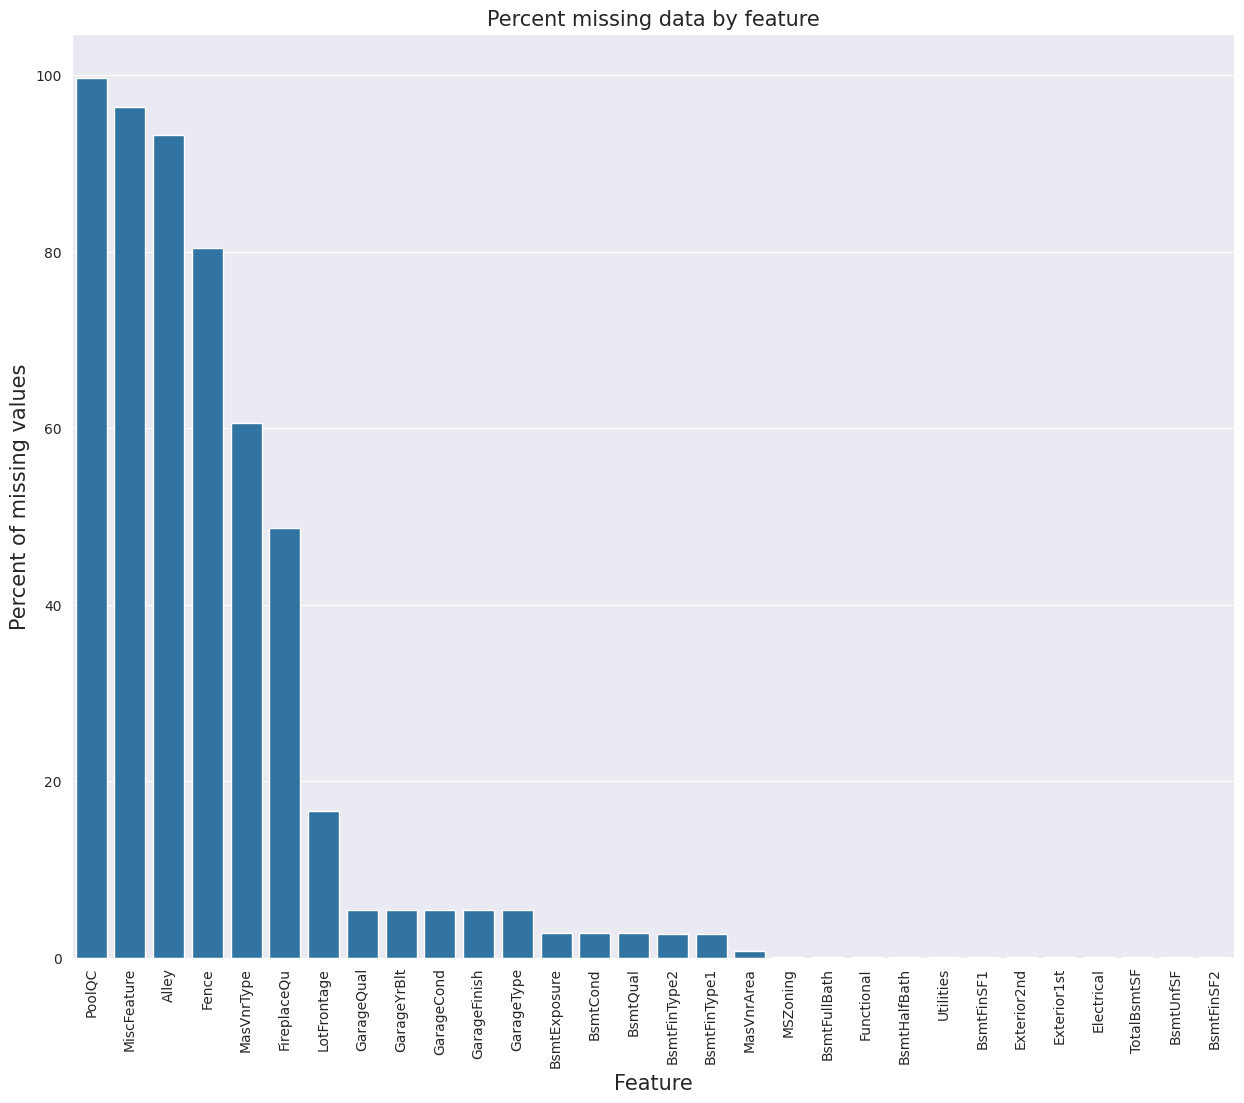

In [11]:
f,ax=plt.subplots(figsize=(15,12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index,y=all_data_na)
plt.xlabel('Feature',fontsize=15)
plt.ylabel('Percent of missing values',fontsize=15)
plt.title('Percent missing data by feature',fontsize=15)

Data Correlation

<Axes: >

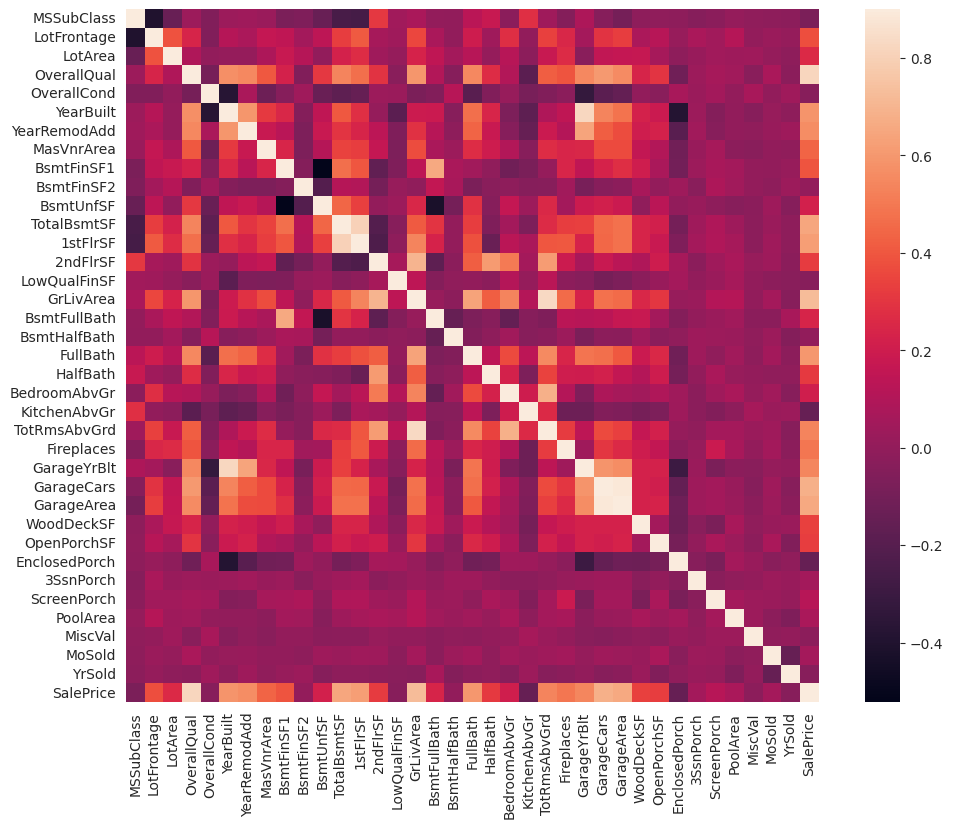

In [12]:
corrmat=train_df.select_dtypes(include=['number']).corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,square=True)

Inputing missing values

- PoolQC: NA값은 'No Pool' 의미
  - 'None'으로 대체

In [13]:
all_data['PoolQC']=all_data['PoolQC'].fillna('None')

- MiscFeature: NA값은 'no misc feature'
  - 'None'으로 대체
- Alley, Fence, FireplaceQu도 동일하게 처리

In [14]:
all_data['MiscFeature']=all_data['MiscFeature'].fillna('None')
all_data['Alley']=all_data['Alley'].fillna('None')
all_data['Fence']=all_data['Fence'].fillna('None')
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna('None')

- LotFrontage: 거리와 집의 거리 요소
  - 이웃들의 중앙값으로 대체

In [15]:
all_data['LotFrontage']=all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

- GarageType, GarageFinish, GarageQual and GarageCond
  - 'None'으로 대체

In [16]:
for col in ('GarageType','GarageFinish','GarageQual','GarageCond'):
  all_data[col]=all_data[col].fillna('None')

- 빈 데이터들을 'None' 또는 0으로 처리

In [17]:
for col in ('GarageYrBlt','GarageArea','GarageCars'):
  all_data[col]=all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
  all_data[col]=all_data[col].fillna(0)

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- MSZoning(The general zoning classification)
  - 최빈값으로 대체

In [21]:
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

- Utilities: 모든 값이 "AllPub", 1개의 "NoSeWa", 2개의 "NA"
  - 예측에 필요해보이지 X, drop 진행

In [22]:
all_data=all_data.drop(['Utilities'],axis=1)

- Functional: NA값은 typical 의미
  - 'Typ'으로 대체

In [23]:
all_data['Functional']=all_data['Functional'].fillna('Typ')

- Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType
  - 최빈값으로 대체

In [24]:
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [25]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [26]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [29]:
# Check remaining missing values if any
all_data_na=(all_data.isnull().sum()/len(all_data))*100
all_data_na=all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)
missing_data=pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head()

,Missing Ratio


More features engineering
- Transforming some numerical variable that are really categorical

In [30]:
# MSSubClass=The building class
all_data['MSSubClass']=all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond']=all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features
all_data['YrSold']=all_data['YrSold'].astype(str)
all_data['MoSold']=all_data['MoSold'].astype(str)

- Label Encoding some categorical variables that may contain information in their ordering set

In [31]:
from sklearn.preprocessing import LabelEncoder
cols=('FireplaceQu','BsmtQual','BsmtCond','GarageQual','GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl=LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c]=lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


Adding one more important feature
- 주택 가격에서 중요한 요소 중 하나는 집의 가용 평수 -> basement + 1st floot + 2nd floor 공간으로 새로운 특성 생성

In [32]:
all_data['TotalSF']=all_data['TotalBsmtSF']+all_data['1stFlrSF']+all_data['2ndFlrSF']

Skewed feature

In [33]:
numeric_feats=all_data.dtypes[all_data.dtypes!='object'].index

# 수치형 데이터에서 skewness 체크
skewed_feats=all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

print('\n Skew in numerical features: \n')
skewness=pd.DataFrame({'Skew':skewed_feats})
skewness.head(10)


 Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [34]:
skewness=skewness[abs(skewness)>0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features=skewness.index
lam=0.15
for feat in skewed_features:
  all_data[feat]=boxcox1p(all_data[feat],lam)

There are 59 skewed numerical features to Box Cox transform


Getting dummy categorical features

In [35]:
all_data=pd.get_dummies(all_data)
print(all_data.shape)

train_df=all_data[:ntrain]
test_df=all_data[ntrain:]

(2917, 220)


#### Modeling

Import Libraries

In [36]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Define a cross validation strategy

In [37]:
# Validation function
n_folds=5

def rmsle_cv(model):
  kf=KFold(n_folds,shuffle=True,random_state=42).get_n_splits(train_df.values)
  rmse=np.sqrt(-cross_val_score(model,train_df.values,y_train,
                                scoring='neg_mean_squared_error',cv=kf))
  return rmse

#### Base Models

- Lasso Regression
- Elastic Net Regression

In [38]:
lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))
ENet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=.9,random_state=3))

- Kernel Ridge Regression

In [39]:
KRR=KernelRidge(alpha=0.6,kernel='polynomial',degree=2,coef0=2.5)

- Gradient Boosting Regression

In [40]:
GBoost=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,
                                 max_features='sqrt',min_samples_leaf=15,
                                 min_samples_split=10,loss='huber',random_state=5)

- XGBoost

In [41]:
model_xgb=xgb.XGBRegressor(colsample_bytree=0.4603,gamma=0.0468,
                           learning_rate=0.05,max_depth=3,
                           min_child_weight=1.7817,n_estimators=2200,
                           reg_alpha=0.464,reg_lambda=0.8571,
                           subsample=0.5213,silent=1,
                           random_state=7,nthread=-1)

- LightGBM

In [42]:
model_lgb=lgb.LGBMRegressor(objective='regression',num_leaves=5,
                            learning_rate=0.05,n_estimators=720,
                            max_bin=55,bagging_fraction=0.8,
                            bagging_freq=5,feature_fraction=0.2319,
                            feature_fraction_seed=9,bagging_seed=9,
                            min_data_in_leaf=6,min_sum_hessian_in_leaf=11)

Base models scores

In [45]:
score=rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1115 (0.0074)



In [43]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [46]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [47]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [48]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1162 (0.0078)



#### Stacking models

Simplest Stakcing approach: Averaging base models

In [49]:
class AveragingModels(BaseEstimator,RegressorMixin,TransformerMixin):
  def __init__(self,models):
    self.models=models

  # we define clones of the original models to fit the data in
  def fit(self,X,y):
    self.models_=[clone(x) for x in self.models]

    # Train cloned base models
    for model in self.models_:
      model.fit(X,y)

    return self

  # Now we do the predictions for cloned models and average them
  def predict(self,X):
    predictions=np.column_stack([
        model.predict(X) for model in self.models_
    ])
    return np.mean(predictions, axis=1)

Averaged base models score

In [50]:
averaged_models=AveragingModels(models=(ENet,GBoost,KRR,lasso))

score=rmsle_cv(averaged_models)
print('Averaged base models socre: {:.4f} ({:.4f})\n'.format(score.mean(),score.std()))

Averaged base models socre: 0.1087 (0.0077)



In [51]:
averaged_models

AveragingModels(models=(Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('elasticnet',
                                         ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                                    random_state=3))]),
                        GradientBoostingRegressor(learning_rate=0.05,
                                                  loss='huber', max_depth=4,
                                                  max_features='sqrt',
                                                  min_samples_leaf=15,
                                                  min_samples_split=10,
                                                  n_estimators=3000,
                                                  random_state=5),
                        KernelRidge(alpha=0.6, coef0=2.5, degree=2,
                                    kernel='polynomial'),
                        Pipeline(steps=[('robustscaler', RobustScaler()),
                                        ('lasso',
                                         Lasso(alpha=0.0005,
                                               random_state=1))])))

Less simple Stacking: Adding a Meta-model
- meta model 추가, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model 훈련

1. 훈련 데이터를 분리된 데이터셋 train, holdout으로 나눔
2. train 데이터로 훈련
3. holdout 데이터로 테스트
4. 3을 통해 예측값을 구하고, meta model을 통해 그 예측 값으로 모델 학습
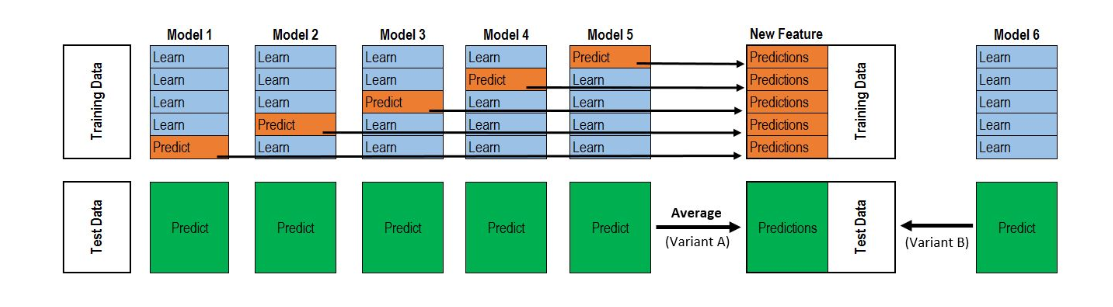

In [55]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacking Averaged models Score

In [56]:
stacked_averaged_models=StackingAveragedModels(
    base_models=(ENet,GBoost,KRR),
    meta_model=(lasso)
)

score=rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


Ensembling StackedRegressor, XGBoost and LightGBM

In [57]:
def rmsle(y,y_pred):
  return np.sqrt(mean_squared_error(y,y_pred))

Final Training and Prediction

StackedRegressor

In [58]:
stacked_averaged_models.fit(train_df.values,y_train)
stacked_train_pred=stacked_averaged_models.predict(train_df.values)
stacked_pred=np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train,stacked_train_pred))

0.078395060966657


XGBoost

In [59]:
model_xgb.fit(train_df,y_train)
xgb_train_pred=model_xgb.predict(train_df)
xgb_pred=np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train,xgb_train_pred))

0.08632034929442625


LightGBM

In [61]:
model_lgb.fit(train_df,y_train)
lgb_train_pred=model_lgb.predict(train_df)
lgb_pred=np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train,lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [62]:
''' RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.7+xgb_train_pred*0.15+lgb_train_pred*0.15))

RMSLE score on train data:
0.0764283320422573


Ensemble Prediction:
- 앙상블에 사용한 가중치에 대해서 Stacked Regressor을 크게 한 이유

Based on their cross-validation scores (and a bit of trial and errors)

You can see for instance in this version of the notebook the following CV mean scores :

StackedRegressor score : 0.1085

Xgboost score: 0.1196

LGBM score: 0.1159

This helps to define the weights. However you may also want to define an optimization function in order to find more optimal weights.

In [63]:
ensemble=stacked_pred*0.7+xgb_pred*0.15+lgb_pred*0.15

Submission

In [64]:
sub=pd.DataFrame()
sub['Id']=test_ID
sub['SalePrice']=ensemble
sub.to_csv('submission.csv',index=False)